# Imports

In [2]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
import os

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, recall_score
from scipy.stats import loguniform, randint
import json
import pickle

import matplotlib.pyplot as plt

# Data cleaning

## Visualisation

In [3]:
df = pd.read_csv(filepath_or_buffer='healthcare-dataset-stroke-data.csv',
                 true_values=['Yes'],
                 false_values=['No'],
                 na_values=['N/A', 'Unknown'],
                 ).drop('id', axis=1)

In [4]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,True,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,True,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,True,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,True,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,True,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   bool   
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     3566 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 404.3+ KB


In [6]:
df = df.dropna(how='any', axis=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3426 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3426 non-null   object 
 1   age                3426 non-null   float64
 2   hypertension       3426 non-null   int64  
 3   heart_disease      3426 non-null   int64  
 4   ever_married       3426 non-null   bool   
 5   work_type          3426 non-null   object 
 6   Residence_type     3426 non-null   object 
 7   avg_glucose_level  3426 non-null   float64
 8   bmi                3426 non-null   float64
 9   smoking_status     3426 non-null   object 
 10  stroke             3426 non-null   int64  
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 297.8+ KB


array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'hypertension'}>],
       [<Axes: title={'center': 'heart_disease'}>,
        <Axes: title={'center': 'avg_glucose_level'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'stroke'}>]], dtype=object)

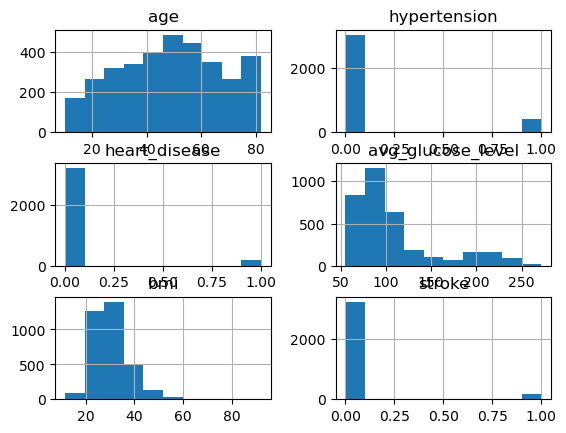

In [8]:
df.hist()

In [9]:
numerical = [col for col in df.columns if df[col].dtype=='float64' and col !='stroke']
categorical = [col for col in df.columns if (df[col].dtype==object or df[col].dtype=='int64' or df[col].dtype==bool) and col !='stroke']

In [10]:
numerical

['age', 'avg_glucose_level', 'bmi']

In [11]:
categorical

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status']

## Splitting

In [12]:
X = df.drop('stroke', axis=1)
y = df['stroke']

In [13]:
y.value_counts()

stroke
0    3246
1     180
Name: count, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=38)

## Preprocessing

In [15]:
col_tr = ColumnTransformer([
    ['num', StandardScaler(), numerical],
    ['cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary').set_output(transform='pandas'), categorical]
])

In [16]:
X_train = col_tr.fit_transform(X_train)
X_test = col_tr.transform(X_test)

# Rapid test of models

In [17]:
models = [LogisticRegression(), RidgeClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), SVC()]

In [18]:
result_rapid = {}

In [19]:
for model in models:
    print(f'Studying model {model} ...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        result_rapid[str(model)] = (f1_score(y_test, y_pred), recall_score(y_test, y_pred))
        print('Results saved in dict.')
    except ValueError as e:
        print(f'There was a ValueError:\n{e}\nThe predicted values were stored instead of the scores.')
        result_rapid[str(model)] = y_pred
    

Studying model LogisticRegression() ...
Results saved in dict.
Studying model RidgeClassifier() ...
Results saved in dict.
Studying model DecisionTreeClassifier() ...
Results saved in dict.
Studying model RandomForestClassifier() ...
Results saved in dict.
Studying model GradientBoostingClassifier() ...
Results saved in dict.
Studying model SVC() ...
Results saved in dict.


In [20]:
for k,v in result_rapid.items():
    if type(v) != np.array:
        print(f'The model {k} gave the following results:')
        print(f'F1 score: {v[0]:.2f}')
        print(f'Recall: {v[1]:.2f}')

The model LogisticRegression() gave the following results:
F1 score: 0.04
Recall: 0.02
The model RidgeClassifier() gave the following results:
F1 score: 0.00
Recall: 0.00
The model DecisionTreeClassifier() gave the following results:
F1 score: 0.08
Recall: 0.09
The model RandomForestClassifier() gave the following results:
F1 score: 0.04
Recall: 0.02
The model GradientBoostingClassifier() gave the following results:
F1 score: 0.04
Recall: 0.02
The model SVC() gave the following results:
F1 score: 0.00
Recall: 0.00


# Random Forest Classifier

In [24]:
scoring = 'accuracy'

## Using GridSearchCV

In [40]:
forestclf = RandomForestClassifier(random_state=38, class_weight='balanced')

In [41]:
param_grid1 = {
    'n_estimators':[10,1000],
    'max_depth':[3,20],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,3]
}

param_grid2 = {
    'n_estimators':[10,100,1000],
    'max_depth':[3,5,20],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,3]
}

param_grid3 = {
    'n_estimators':[10,100,500,1000],
    'max_depth':[3,5,10,20],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,3]
}

param_grid4 = {
    'n_estimators':[10,100,500,1000],
    'max_depth':[3,5,10,15,20],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2,3]
}


In [42]:
result_grid = {i:0 for i in range(5)}
for i, grid in enumerate([param_grid1,param_grid2,param_grid3,param_grid4]):
    grid = GridSearchCV(
        estimator=forestclf,
        scoring=scoring,
        param_grid=grid,
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    result_grid[i] = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 120 candidates, totalling 360 fits


In [43]:
with open('result_grid.pickle', 'wb') as f:
    pickle.dump(result_grid, f)

## Using RandomizedSearchCV

In [50]:
forestclf = RandomForestClassifier(random_state=38, class_weight='balanced')

param_dist = {
    'n_estimators':randint(10,1000),
    'max_depth': randint(3,20),
    'min_samples_split':randint(2,3),
    'min_samples_leaf':randint(1,3)
}

In [51]:
result_rdm = {}

In [52]:
for i,n in enumerate([16,36,64,120]):
    rdmcv = RandomizedSearchCV(
        estimator=forestclf,
        scoring=scoring,
        param_distributions=param_dist,
        n_iter=n,
        return_train_score=True,
        cv=3,
        n_jobs=-1,
        verbose=1,
        random_state=38
    )
    rdmcv.fit(X_train,y_train)
    result_rdm[i] = pd.DataFrame(rdmcv.cv_results_).sort_values(by='rank_test_score')

with open('result_rdm.pickle', 'wb') as f:
    pickle.dump(result_rdm, f)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 120 candidates, totalling 360 fits


## Using HalvingGridSearchCV

In [53]:
forestclf = RandomForestClassifier(random_state=38, class_weight='balanced')

param_grid1 = {
    #'n_estimators':[10,1000],
    'max_depth':[3,20],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,3]
}

param_grid2 = {
    #'n_estimators':[10,100,1000],
    'max_depth':[3,5,20],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,3]
}

param_grid3 = {
    #'n_estimators':[10,100,500,1000],
    'max_depth':[3,5,10,20],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,3]
}

param_grid4 = {
    #'n_estimators':[10,100,500,1000],
    'max_depth':[3,5,10,15,20],
    'min_samples_split':[2,3],
    'min_samples_leaf':[1,2,3]
}

result_hgrid = {i:0 for i in range(5)}
for i, grid in enumerate([param_grid1,param_grid2,param_grid3,param_grid4]):
    hgrid = HalvingGridSearchCV(
        estimator=forestclf,
        param_grid=grid,
        resource='n_estimators',
        max_resources=1000,
        factor=3,
        cv=3,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
        verbose=1
    )
    hgrid.fit(X_train, y_train)
    result_hgrid[i] = pd.DataFrame(hgrid.cv_results_).sort_values(by='rank_test_score')

with open('result_hgrid.pickle', 'wb') as f:
    pickle.dump(result_hgrid, f)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 333
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 333
Fitting 3 folds for each of 8 candidates, totalling 24 fits
----------
iter: 1
n_candidates: 3
n_resources: 999
Fitting 3 folds for each of 3 candidates, totalling 9 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 111
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 111
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 4
n_resources: 333
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 999
Fitting 3 folds for each of 2 candidates, totalling 6 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 111
max_resources_: 1000
aggressive_elimination: False
factor: 3

## Using HalvingRandomSearchCV

In [55]:
forestclf = RandomForestClassifier(random_state=38, class_weight='balanced')

param_dist = {
    #'n_estimators':randint(1,10000),
    'max_depth': randint(3,20),
    'min_samples_split':randint(2,4),
    'min_samples_leaf':randint(1,3)
}

hrdm = HalvingRandomSearchCV(
    estimator=forestclf,
    param_distributions=param_dist,
    resource='n_estimators',
    max_resources=1000,
    factor=3,
    cv=3,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

hrdm.fit(X_train, y_train)

result_hrdm = {}
result_hrdm[0] = pd.DataFrame(hrdm.cv_results_).sort_values(by='rank_test_score')

with open('result_hrdm.pickle', 'wb') as f:
    pickle.dump(result_hrdm, f)


n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 1
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1000
n_resources: 1
Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
----------
iter: 1
n_candidates: 334
n_resources: 3
Fitting 3 folds for each of 334 candidates, totalling 1002 fits
----------
iter: 2
n_candidates: 112
n_resources: 9
Fitting 3 folds for each of 112 candidates, totalling 336 fits
----------
iter: 3
n_candidates: 38
n_resources: 27
Fitting 3 folds for each of 38 candidates, totalling 114 fits
----------
iter: 4
n_candidates: 13
n_resources: 81
Fitting 3 folds for each of 13 candidates, totalling 39 fits
----------
iter: 5
n_candidates: 5
n_resources: 243
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 2
n_resources: 729
Fitting 3 folds for each of 2 candidates, totalling 6 fits


## Plot

### Plot by steps

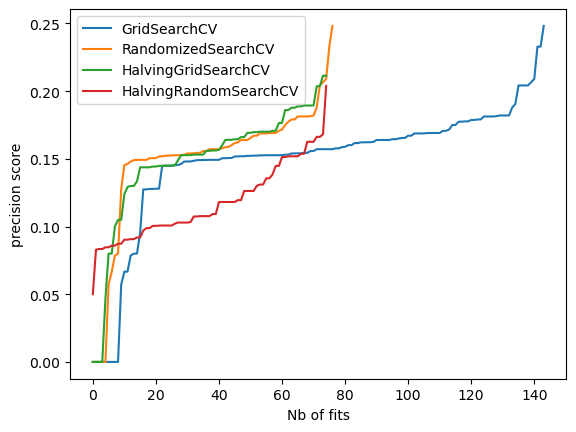

In [34]:
plt.plot(range(len(df_grid)), df_grid[['mean_test_score']].sort_values('mean_test_score'), label='GridSearchCV')
plt.plot(range(len(df_rdmcv)), df_rdmcv[['mean_test_score']].sort_values('mean_test_score'), label='RandomizedSearchCV')
plt.plot(range(len(df_hgrid)), df_hgrid[['mean_test_score']].sort_values('mean_test_score'), label='HalvingGridSearchCV')
plt.plot(range(len(df_hrdm)), df_hrdm[['mean_test_score']].sort_values('mean_test_score'), label='HalvingRandomSearchCV')
plt.xlabel('Nb of fits')
plt.ylabel(f'{scoring} score')
plt.legend()
plt.show;

### Plot by time

In [35]:
df_grid = df_grid.sort_values('mean_test_score')
df_rdmcv = df_rdmcv.sort_values('mean_test_score')
df_hgrid = df_hgrid.sort_values('mean_test_score')
df_hrdm = df_hrdm.sort_values('mean_test_score')



df_grid['cumulated_time'] = df_grid['mean_fit_time'].cumsum(axis=0)
df_rdmcv['cumulated_time'] = df_rdmcv['mean_fit_time'].cumsum(axis=0)
df_hgrid['cumulated_time'] = df_hgrid['mean_fit_time'].cumsum(axis=0)
df_hrdm['cumulated_time'] = df_hrdm['mean_fit_time'].cumsum(axis=0)

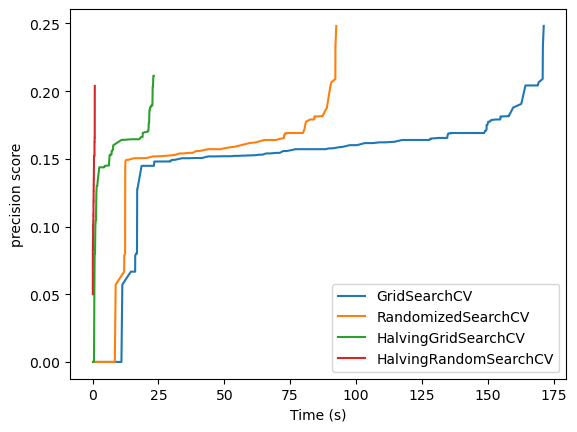

In [36]:
plt.plot(df_grid['cumulated_time'], df_grid[['mean_test_score']], label='GridSearchCV')
plt.plot(df_rdmcv['cumulated_time'], df_rdmcv[['mean_test_score']], label='RandomizedSearchCV')
plt.plot(df_hgrid['cumulated_time'], df_hgrid[['mean_test_score']], label='HalvingGridSearchCV')
plt.plot(df_hrdm['cumulated_time'], df_hrdm[['mean_test_score']], label='HalvingRandomSearchCV')
plt.xlabel('Time (s)')
plt.ylabel(f'{scoring} score')
plt.legend()
plt.show;

# CarbonTracker

In [41]:
def perform_search(search_type, 
                   classifier, 
                   scoring, 
                   param_grid, 
                   n_iter=100, 
                   cv=5, 
                   verbose=3, 
                   resource='n_estimator', 
                   max_resource=1000,
                   factor=3,
                   random_state=38,
                   carbontracker=False):
    
    clf = classifier(random_state=38, class_weight='balanced')
    
    match search_type:
        case 'GridSearchCV':
            search = GridSearchCV(
                estimator=clf,
                scoring=scoring,
                param_grid=param_grid,
                return_train_score=True,
                cv=cv,
                n_jobs=-1,
                verbose=verbose
        )
    
        case 'RandomizedSearchCV':
            search = RandomizedSearchCV(
                estimator=clf,
                scoring=scoring,
                param_distributions=param_grid,
                n_iter=n_iter,
                return_train_score=True,
                cv=cv,
                n_jobs=-1,
                verbose=verbose,
                random_state=random_state
        )
        case 'HalvingGridSearchCV':
            search = HalvingGridSearchCV(
                estimator=clf,
                param_grid=param_grid,
                resource=resource,
                max_resources=max_resource,
                factor=factor,
                cv=cv,
                scoring=scoring,
                return_train_score=True,
                n_jobs=-1,
                verbose=verbose,
                random_state=random_state
        )
        case 'HalvingRandomSearchCV':
            search = HalvingRandomSearchCV(
                estimator=clf,
                param_distributions=param_grid,
                resource=resource,
                max_resources=max_resource,
                factor=factor,
                cv=cv,
                scoring=scoring,
                return_train_score=True,
                n_jobs=-1,
                verbose=verbose,
                random_state=random_state
        )
    
    if carbontracker=True:
    search.fit(X_train, y_train)

    df_search = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')
    
    return search, df_search

In [42]:
perform_search('GridSearchCV', 
               RandomForestClassifier, 
               scoring='f1', 
               param_grid=param_grid)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 2/5] END max_depth=14, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.000) total time=   0.3s
[CV 1/5] END max_depth=14, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.000) total time=   0.4s
[CV 3/5] END max_depth=14, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.000) total time=   0.4s
[CV 4/5] END max_depth=14, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.000) total time=   0.4s
[CV 5/5] END max_depth=14, min_samples_leaf=1, min_samples_split=2;, score=(train=1.000, test=0.000) total time=   0.3s
[CV 2/5] END max_depth=14, min_samples_leaf=1, min_samples_split=3;, score=(train=1.000, test=0.000) total time=   0.3s
[CV 1/5] END max_depth=14, min_samples_leaf=1, min_samples_split=3;, score=(train=1.000, test=0.000) total time=   0.3s
[CV 3/5] END max_depth=14, min_samples_leaf=1, min_samples_split=3;, score=(train=1.000, test=0.00

(GridSearchCV(cv=5,
              estimator=RandomForestClassifier(class_weight='balanced',
                                               random_state=38),
              n_jobs=-1,
              param_grid={'max_depth': array([14, 18, 14,  5,  9, 12,  4, 17, 15, 18]),
                          'min_samples_leaf': [1, 2, 3],
                          'min_samples_split': [2, 3]},
              return_train_score=True, scoring='f1', verbose=3),
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
 20       0.271275      0.013747         0.014794        0.000693   
 21       0.265199      0.012627         0.014590        0.000597   
 22       0.269819      0.012000         0.014335        0.000507   
 23       0.271682      0.010073         0.015400        0.001449   
 19       0.270825      0.008766         0.014977        0.000203   
 18       0.267958      0.009323         0.014807        0.000690   
 37       0.256994      0.009325         0.014808        0.000851   
